In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists
import opendatasets as od
import shutil
import wbgapi as wb

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

import requests
from io import BytesIO

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'olympics_bayes')))
rng = np.random.default_rng(SEED)

# Load Data

Our data is complete for all games since 1960. We are only including Summer Olympics.

In [92]:
df_hosts = pd.read_csv("../Data/clean/hosts_summer.csv", keep_default_na=False)
df_hosts = df_hosts.loc[df_hosts["year"]>=1960]

In [95]:
df_medal_count = pd.read_csv("../Data/clean/medal_count.csv", keep_default_na=False)
df_medal_total = pd.read_csv("../Data/clean/medal_total.csv", keep_default_na=False)
df_medal_total.rename(columns={"Gold":"Gold_sum","Silver":"Silver_sum","Bronze":"Bronze_sum","Total":"Total_sum"}, inplace=True)
df_medal_pct = pd.read_csv("../Data/clean/medal_pct.csv", keep_default_na=False)
df_won_before = pd.read_csv("../Data/clean/won_before.csv", keep_default_na=False)
df_participant = pd.read_csv("../Data/clean/participant.csv",keep_default_na=False)
df_participant['athletes_pct'] = pd.to_numeric(df_participant['athletes_pct'], errors='coerce')
df_participant['athletes_pct'].fillna(0, inplace=True)
df_gdp = pd.read_csv("../Data/clean/gdp.csv", keep_default_na=False)
df_gdp_pct = pd.read_csv("../Data/clean/pct_gdp.csv", keep_default_na=False)
df_gdp_pc = pd.read_csv("../Data/clean/gdp_pc.csv", keep_default_na=False)

df_pop_pct = pd.read_csv("../Data/clean/pct_pop.csv", keep_default_na=False)

df_free = pd.read_csv("../Data/clean/freedom.csv", keep_default_na=False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/3257439763.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_participant['athletes_pct'].fillna(0, inplace=True)


In [96]:
df = df_participant[["game_id","country_code","participant","athletes_pct"]]
df = pd.merge(df, df_hosts[['game_id','host_country','year']], on='game_id', how='right')
df['host_country'] = np.where(df['country_code'] == df['host_country'], 1, 0)
df = pd.merge(df, df_medal_pct[['game_id','country_code','Gold_pct', 'Silver_pct',
       'Bronze_pct', 'Total_pct']], on=['game_id','country_code'], how='left')
df = pd.merge(df, df_medal_count[['game_id','country_code','Gold', 'Silver',
       'Bronze', 'Total']], on=['game_id','country_code'], how='left')
df = pd.merge(df, df_medal_total[['game_id','Gold_sum', 'Silver_sum',
       'Bronze_sum', 'Total_sum']], on=['game_id'], how='left')
df = df.fillna(0)
df = pd.merge(df, df_gdp[['country_code','gdp','year']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pct[['country_code','year','pct_gdp']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pc[['country_code','year','gdp_pc']], on=['year','country_code'], how='left')
df = pd.merge(df, df_pop_pct[['country_code','year','pct_pop']], on=['year','country_code'], how='left')
df = pd.merge(df, df_free[['country_code','year','free']], on=['year','country_code'], how='left')

In [97]:
df[['gdp','pct_gdp','gdp_pc','athletes_pct']] = df[['gdp','pct_gdp','gdp_pc','athletes_pct']].astype(np.float64)

df['free_norm'] = (df['free'] - df['free'].mean()) / df['free'].std()

df = df.loc[df['participant'] == 1]

df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']] = 100*df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']]

df['country_code'] = df['country_code'].astype(CategoricalDtype())

We will train on all games before Tokyo 2020, and then use those games as our validation for our model.

In [412]:
df_test = df.loc[df["year"] == 2021]
df_train = df.loc[df["year"] < 2021]

In [413]:
df_train = df_test[df_test['country_code'].isin(df_train['country_code'].cat.categories)]

## Model

In [64]:
import pytensor.tensor as at
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

COORDS = {'country_code':df_train['country_code'].cat.categories.values, 
          "obs_idx": df_train.index}

with pm.Model(coords=COORDS) as model:
    # Priors for coefficients
    sigma = pm.HalfCauchy("sigma", beta=1)

    alpha_gdp = pm.Normal('alpha_gdp', mu=0, sigma=1)
    alpha_pop = pm.Normal('alpha_pop', mu=0, sigma=1)
    alpha_free = pm.Normal('alpha_free', mu=0, sigma=1)
    alpha_host = pm.Normal('alpha_host', mu=0, sigma=1)
    alpha_athletes = pm.Normal('alpha_athletes', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    country_effect_mu = pm.Normal('country_effect_mu', 0, 1)
    country_effect_sigma = pm.Gamma('country_effect_sigma', alpha=2, beta=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims="country_code")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset, dims="country_code")

    gdp = at.as_tensor_variable(df_train['pct_gdp'].values)
    pop = at.as_tensor_variable(df_train['pct_pop'].values)
    free = at.as_tensor_variable(df_train['free'].values)
    host = at.as_tensor_variable(df_train['host_country'].values)
    athletes = at.as_tensor_variable(df_train['athletes_pct'].values)
    medals = at.as_tensor_variable(df_train['Total_pct'].values)

    country_data = pm.Data('country_data', df_train['country_code'].cat.codes.to_numpy(), dims="obs_idx")

    # Define likelihood
    likelihood = (1 + alpha_host*host)*(intercept + country_effect[country_data] +
        alpha_gdp * 100 * gdp +
        alpha_pop * 100 * pop +
        alpha_free * free)

    y_hat = pm.Normal('y_hat', mu=likelihood, sigma=sigma, observed=medals)
    
    idata = pm.sample(nuts_sampler='nutpie')
    idata = pm.sample_posterior_predictive(idata, 
                                            predictions=True, 
                                            **POST_PRED_KWARGS).assign_coords({"obs_idx":df_train.index})

Sampling: [y_hat]


Output()

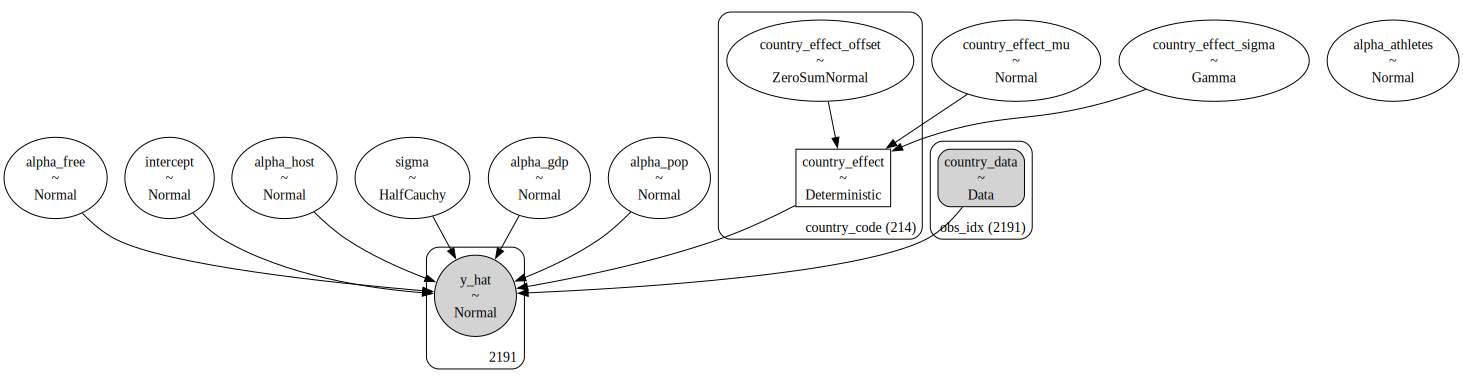

In [65]:
pm.model_to_graphviz(model)

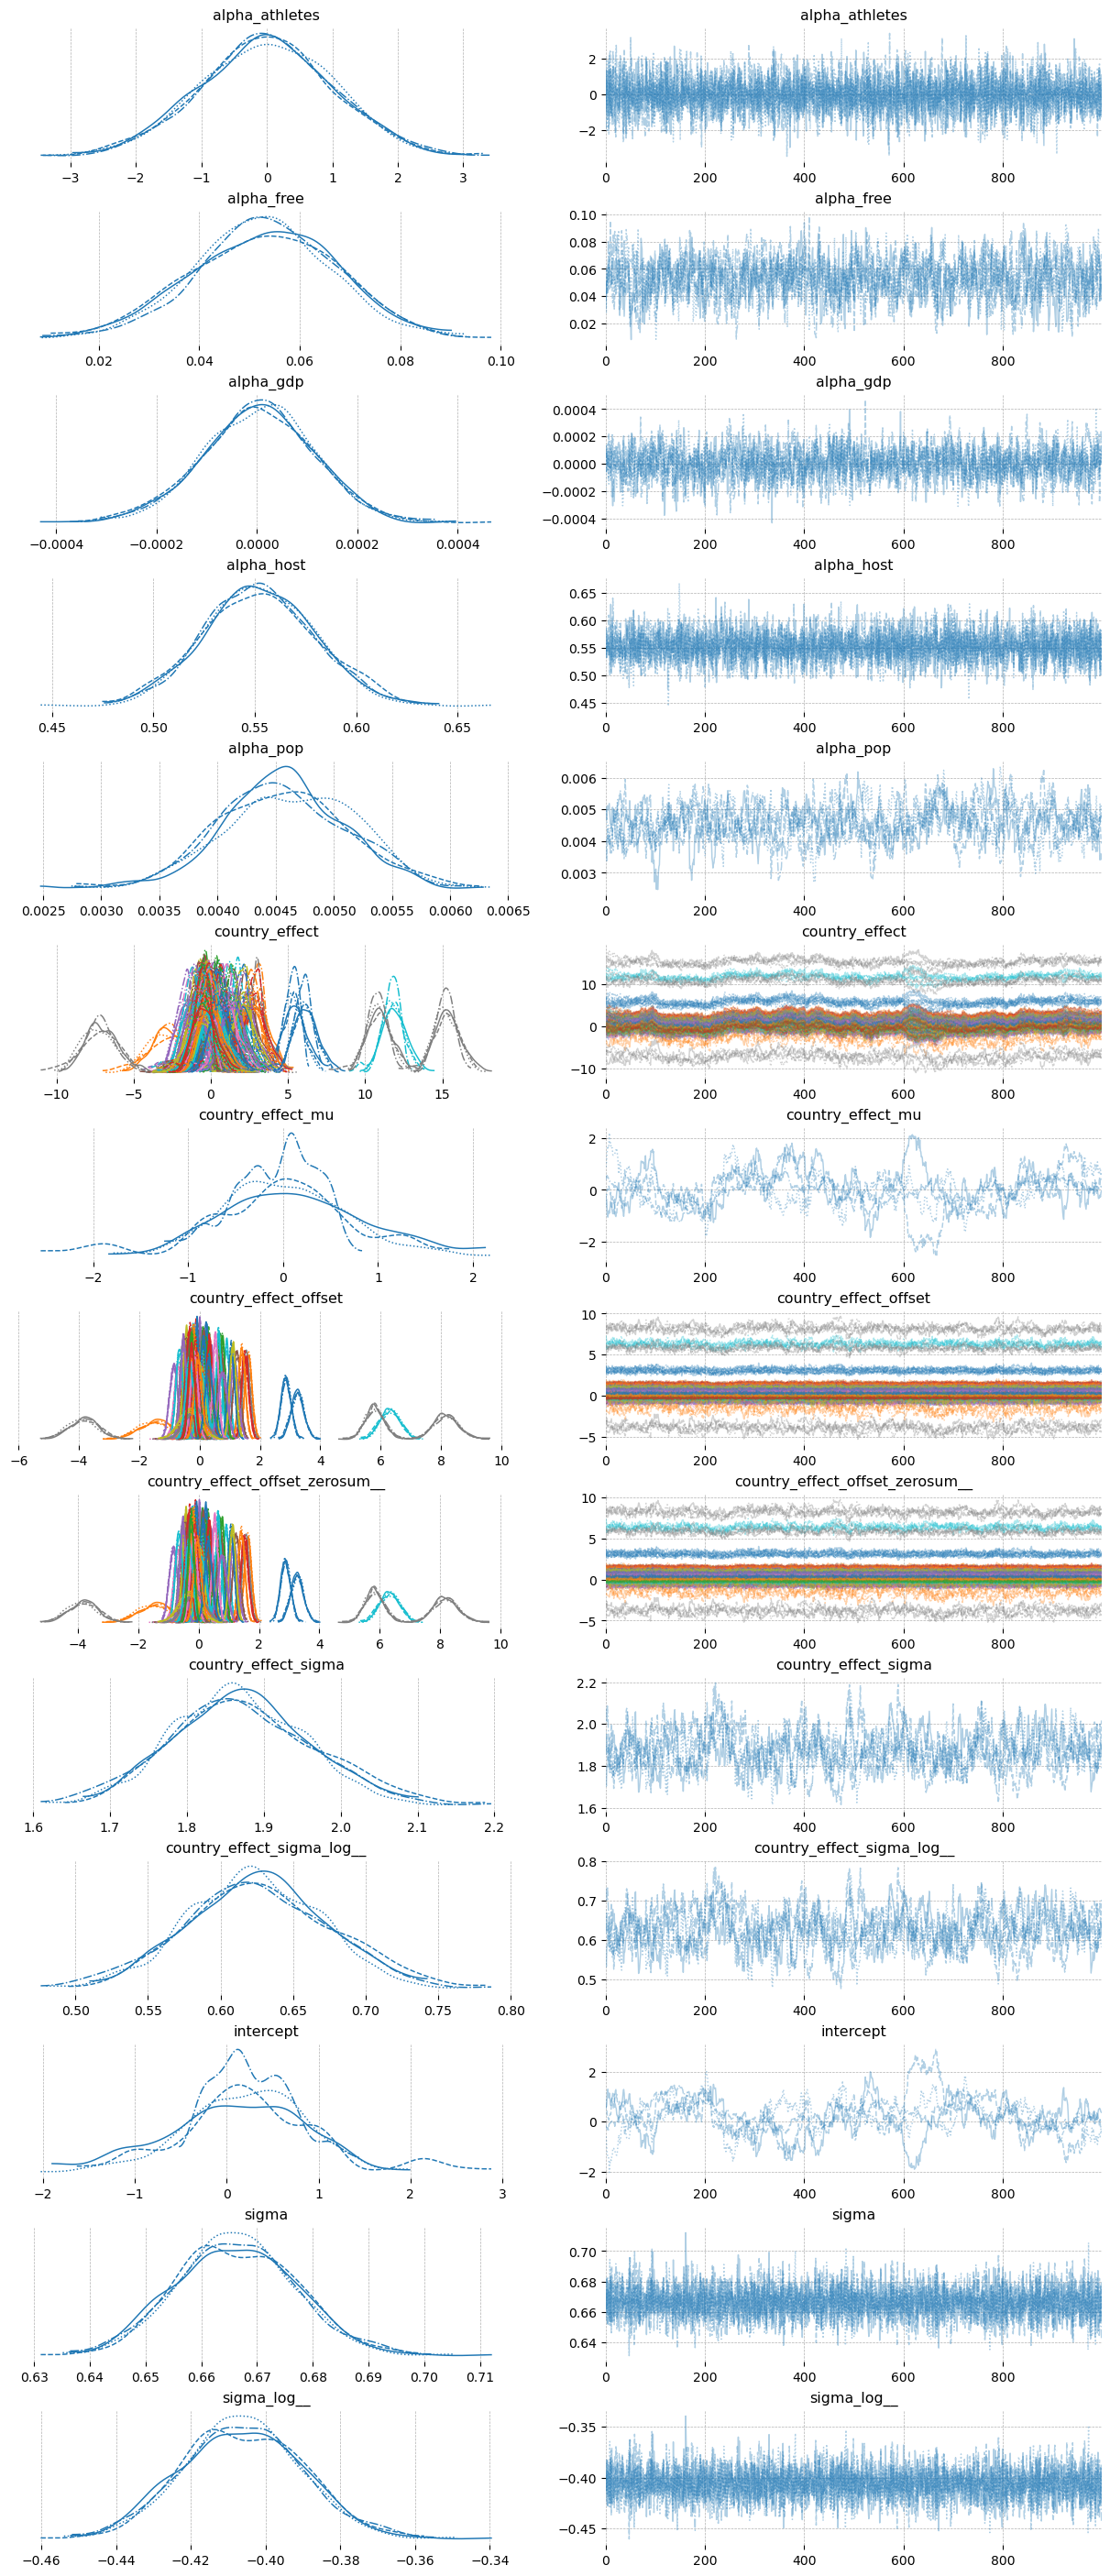

In [66]:
az.plot_trace(idata);

In [67]:
predictions = np.mean(idata.predictions['y_hat'], axis=(0, 1))

In [68]:
hdi_mean = az.hdi(idata.predictions.y_hat)

hdi = pd.DataFrame(hdi_mean['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high'] = hdi['high']
df_train['low'] = hdi['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/4162940493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high'] = hdi['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/4162940493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low'] = hdi['low']


In [69]:
hdi_mean_50 = az.hdi(idata.predictions.y_hat, hdi_prob=.5)

hdi_50 = pd.DataFrame(hdi_mean_50['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high_50'] = hdi_50['high']
df_train['low_50'] = hdi_50['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/752352581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high_50'] = hdi_50['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/752352581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low_50'] = hdi_50['low']


In [70]:
df_train['preds'] = predictions

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/1527421163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['preds'] = predictions


In [71]:
df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/3709973698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2


<Axes: xlabel='Total_pct', ylabel='preds'>

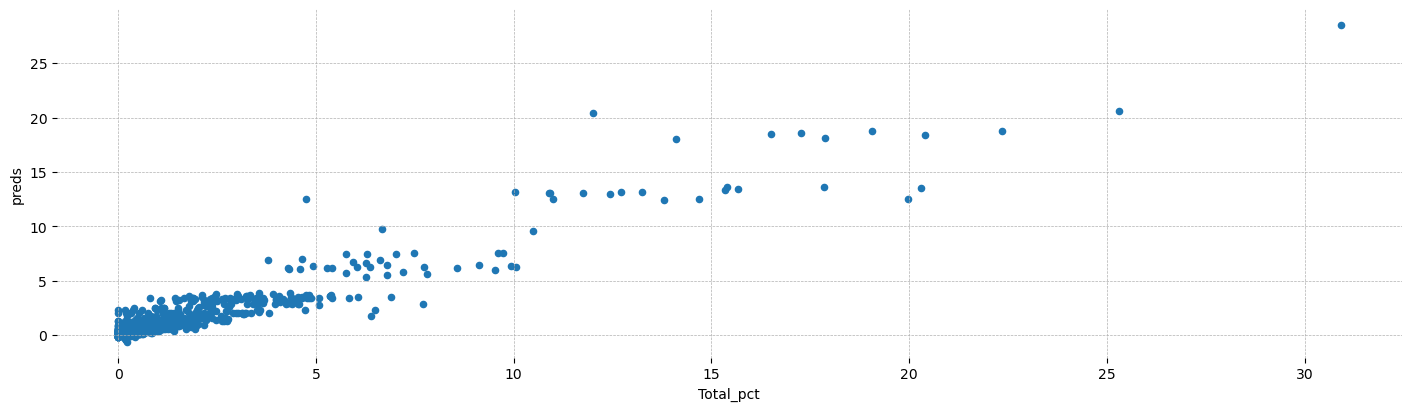

In [72]:
df_train.plot.scatter(x='Total_pct',y='preds')

In [440]:
df_test = df.loc[df["year"] == 2021]
df_train = df.loc[df["year"] < 2021]
df_test = df_test[df_test['country_code'].isin(df_train['country_code'].cat.categories)]

In [446]:
df_train['country_code'].unique()

['AD', 'AR', 'AT', 'AU', 'BE', ..., 'MR', 'YU', 'DD', 'YD', 'RH']
Length: 214
Categories (214, object): ['AD', 'AE', 'AF', 'AG', ..., 'YU', 'ZA', 'ZM', 'ZW']

In [441]:
# Extract unique years and create categorical variable
years = df_train['year'].unique()
df_train['year'] = pd.Categorical(df_train['year'], categories=years)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97687/2839851630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['year'] = pd.Categorical(df_train['year'], categories=years)


In [556]:
len(country_codes_idx)

2191

In [567]:
COORDS = {'country_code':df_train['country_code'].values,
          'year':df_train['year'].cat.categories.values, 
          "obs_idx": df_train.index}

# Model construction
with pm.Model(coords=COORDS) as model:
    # Priors for coefficients
    alpha_gdp = pm.Cauchy('alpha_gdp', alpha=0, beta=0.1)
    alpha_pop = pm.HalfCauchy('alpha_pop', beta=0.1)
    alpha_free = pm.HalfCauchy('alpha_free', beta=0.1)
    alpha_host = pm.HalfCauchy('alpha_host', beta=0.1)
    alpha_athletes = pm.HalfCauchy('alpha_athletes', beta=0.1)

    intercept = pm.Cauchy('intercept', alpha=0, beta=1, dims="country_code")

    psi = pm.Beta('psi', alpha=1, beta=20)

    # Loop over each year to define separate Zero-Inflated Poisson distributions
    for year in years:
        df_year = df_train[df_train['year'] == year]

        gdp = df_year['pct_gdp'].values
        pop = df_year['pct_pop'].values
        free = df_year['free'].values
        host = df_year['host_country'].values
        athletes = df_year['athletes_pct'].values
        medals = df_year['Total'].values

        country_data = df_year['country_code'].cat.codes.to_numpy()

        # Calculate logits for the Zero-Inflated Poisson likelihood
        logits = (intercept[country_data] + (1 + alpha_host * host) * (alpha_gdp * gdp +
                                                                     alpha_pop * pop +
                                                                    alpha_free * free +
                                                                     alpha_athletes * athletes))

        # Convert logits to probabilities using softmax
        probs = pm.math.softmax(logits)

        # Define likelihood as Zero-Inflated Poisson for each year separately
        medals = df_year[['Total']].values  # Total medal counts (gold + silver + bronze)
        
        # Zero-Inflated Poisson model
        #psi = pm.Beta(f'psi_{year}', alpha=1, beta=20)  # Probability of observing a zero
        mu = pm.Deterministic(f'mu_{year}', probs * df_year['Total_sum'])  # Expected count (mean)
        y_hat = pm.ZeroInflatedPoisson(f'y_hat_{year}', psi=psi, mu=mu, observed=medals.ravel())

    # Sample from the model
    idata = pm.sample(nuts_sampler='nutpie')

    # Sample posterior predictive for out-of-sample predictions
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=[f'y_hat_{year}' for year in df_train['year'].unique()])
    
    # Assign coordinates for clearer interpretation
    posterior_predictive.assign_coords(
        {'country_code': country_coords, "obs_idx": df_train.index}
    )

Sampling: [y_hat_1960, y_hat_1964, y_hat_1968, y_hat_1972, y_hat_1976, y_hat_1980, y_hat_1984, y_hat_1988, y_hat_1992, y_hat_1996, y_hat_2000, y_hat_2004, y_hat_2008, y_hat_2012, y_hat_2016]


Output()

In [541]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

In [542]:
a = posterior_predictive.assign_coords(
        {'country_code': country_coords, "obs_idx": df_train.index}
    )

In [545]:
a.posterior_predictive

<xarray.Dataset> Size: 70MB
Dimensions:           (chain: 4, draw: 1000, y_hat_1960_dim_2: 85,
                       y_hat_1964_dim_2: 92, y_hat_1968_dim_2: 106,
                       y_hat_1972_dim_2: 119, y_hat_1976_dim_2: 107,
                       y_hat_1980_dim_2: 77, y_hat_1984_dim_2: 134,
                       y_hat_1988_dim_2: 156, y_hat_1992_dim_2: 165,
                       y_hat_1996_dim_2: 183, y_hat_2000_dim_2: 185,
                       y_hat_2004_dim_2: 190, y_hat_2008_dim_2: 196,
                       y_hat_2012_dim_2: 197, y_hat_2016_dim_2: 199,
                       country_code: 214, obs_idx: 2191)
Coordinates: (12/19)
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * y_hat_1960_dim_2  (y_hat_1960_dim_2) int64 680B 0 1 2 3 4 ... 80 81 82 83 84
  * y_hat_1964_dim_2  (y_hat_1964_dim_2) int64 736B 0 1 2 3 4 ... 87 88 89 90 91
  * y_hat_1968_dim_2  (y_hat_1968_dim_2) int64 848B 0 1 2 3 ... 102 103 104 105
  * y_hat_1972_dim_2  (y_hat_1972_dim_2) int64 952B 0 1 2 3 ... 115 116 117 118
    ...                ...
  * y_hat_2004_dim_2  (y_hat_2004_dim_2) int64 2kB 0 1 2 3 4 ... 186 187 188 189
  * y_hat_2008_dim_2  (y_hat_2008_dim_2) int64 2kB 0 1 2 3 4 ... 192 193 194 195
  * y_hat_2012_dim_2  (y_hat_2012_dim_2) int64 2kB 0 1 2 3 4 ... 193 194 195 196
  * y_hat_2016_dim_2  (y_hat_2016_dim_2) int64 2kB 0 1 2 3 4 ... 195 196 197 198
  * country_code      (country_code) object 2kB 'AD' 'AE' 'AF' ... 'ZM' 'ZW'
  * obs_idx           (obs_idx) int64 18kB 214 216 217 218 ... 3408 3413 3420
Data variables: (12/15)
    y_hat_1960        (chain, draw, y_hat_1960_dim_2) int64 3MB 0 1 1 ... 0 0 0
    y_hat_1964        (chain, draw, y_hat_1964_dim_2) int64 3MB 0 0 3 ... 0 0 0
    y_hat_1968        (chain, draw, y_hat_1968_dim_2) int64 3MB 0 2 4 ... 0 0 70
    y_hat_1972        (chain, draw, y_hat_1972_dim_2) int64 4MB 0 4 2 ... 0 78 0
    y_hat_1976        (chain, draw, y_hat_1976_dim_2) int64 3MB 0 0 1 ... 0 0 55
    y_hat_1980        (chain, draw, y_hat_1980_dim_2) int64 2MB 0 5 0 ... 0 104
    ...                ...
    y_hat_1996        (chain, draw, y_hat_1996_dim_2) int64 6MB 2 0 2 ... 0 0 0
    y_hat_2000        (chain, draw, y_hat_2000_dim_2) int64 6MB 0 1 1 ... 0 0 0
    y_hat_2004        (chain, draw, y_hat_2004_dim_2) int64 6MB 0 0 3 ... 0 0 0
    y_hat_2008        (chain, draw, y_hat_2008_dim_2) int64 6MB 0 0 3 ... 0 7 0
    y_hat_2012        (chain, draw, y_hat_2012_dim_2) int64 6MB 0 0 7 ... 0 6 0
    y_hat_2016        (chain, draw, y_hat_2016_dim_2) int64 6MB 0 2 7 ... 1 0 0
Attributes:
    created_at:                 2024-07-02T22:47:24.388859+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.1

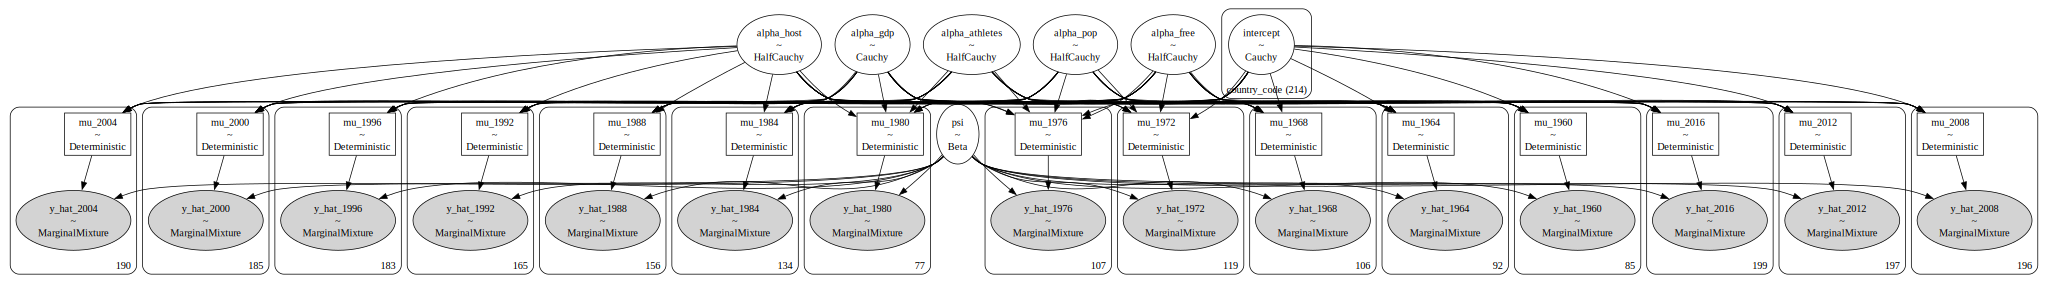

In [454]:
pm.model_to_graphviz(model)

In [456]:
posterior_predictives[2016]

Inference data with groups:
	> posterior_predictive
	> observed_data

In [461]:
a = np.mean(posterior_predictives[2000].posterior_predictive.y_hat_2000, axis=(0, 1)).to_series()

b = posterior_predictives[2000].observed_data.y_hat_2000.to_series()

df_result = pd.DataFrame()

df_result['a'] = a
df_result['b'] = b

<Axes: xlabel='b', ylabel='a'>

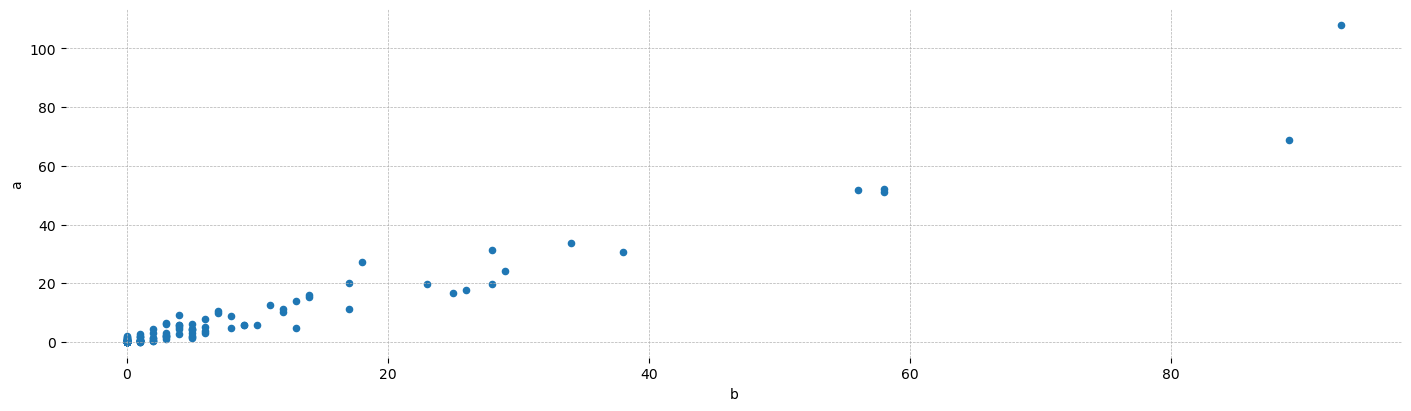

In [462]:
df_result.plot.scatter(x='b',y='a')

In [463]:
df_result['country_code'] = (df_train.loc[df_train['year'] == 2000, 'country_code']).astype('string').reset_index()['country_code']

df_result['error'] = (df_result['b']-df_result['a'])**2

df_result.sort_values(by='error', ascending=False).head(10)

,a,b,country_code,error
y_hat_2000_dim_2,,,,
154,68.93425,89,RU,402.634323
60,107.94375,93,US,223.315664
34,27.21650,18,JP,84.943872
46,16.65225,25,NL,69.684930
52,17.68450,26,RO,69.147540
36,19.79175,28,KR,67.375368
25,4.92300,13,GR,65.237929
23,30.79050,38,FR,51.976890
13,51.20925,58,CN,46.114286


In [ ]:
df_result.sort_values(by='a', ascending=False).head(10)

In [464]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 0 to 212
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   game_id       190 non-null    object  
 1   country_code  190 non-null    category
 2   participant   190 non-null    float64 
 3   athletes_pct  190 non-null    float64 
 4   host_country  190 non-null    int64   
 5   year          190 non-null    int64   
 6   Gold_pct      190 non-null    float64 
 7   Silver_pct    190 non-null    float64 
 8   Bronze_pct    190 non-null    float64 
 9   Total_pct     190 non-null    float64 
 10  Gold          190 non-null    float64 
 11  Silver        190 non-null    float64 
 12  Bronze        190 non-null    float64 
 13  Total         190 non-null    float64 
 14  Gold_sum      190 non-null    float64 
 15  Silver_sum    190 non-null    float64 
 16  Bronze_sum    190 non-null    float64 
 17  Total_sum     190 non-null    float64 
 18  gdp           1

In [ ]:
az.plot_trace(trace);

In [568]:
with model:
    gdp = df_test['pct_gdp'].values
    pop = df_test['pct_pop'].values
    free = df_test['free'].values
    host = df_test['host_country'].values
    athletes = df_test['athletes_pct'].values
    country_data = df_test['country_code'].cat.codes.to_numpy()

    # Use the posterior samples from the fitted model
    logits = (idata.posterior['intercept'].mean(dim=("chain", "draw")).values[country_data] + 
              (1 + idata.posterior['alpha_host'].mean(dim=("chain", "draw")).values * host) *
              (idata.posterior['alpha_gdp'].mean(dim=("chain", "draw")).values * gdp +
               idata.posterior['alpha_pop'].mean(dim=("chain", "draw")).values * pop +
               idata.posterior['alpha_free'].mean(dim=("chain", "draw")).values * free +
               idata.posterior['alpha_athletes'].mean(dim=("chain", "draw")).values * athletes))

    probs = pm.math.softmax(logits)
    mu_test = probs * df_test['Total_sum'].values

    # Sample from the posterior predictive for the new year
    test_samples = pm.sample_posterior_predictive(idata, var_names=['mu'], model=model, samples=500)
    
    # Convert samples to posterior predictions for the new year
    test_predictions = test_samples['mu']


TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'

In [494]:
posterior_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [467]:
df_result = pd.DataFrame()

df_result['pred'] = np.mean(posterior_pred.posterior_predictive['y_hat_pred'], axis=(0, 1)).to_series()
df_result['actual'] = df_test['Total']
df_result['country_code'] = df_test['country_code']

<Axes: xlabel='actual', ylabel='pred'>

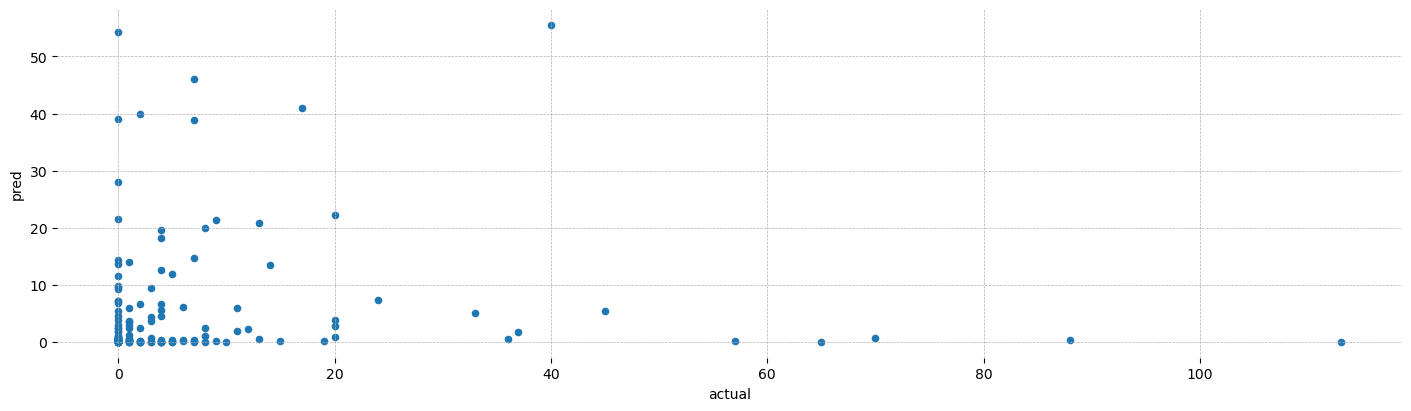

In [468]:
df_result.plot.scatter(x='actual',y='pred')

In [469]:
df_result['country_code'] = (df_test['country_code']).astype('string').reset_index()['country_code']

df_result['error'] = (df_result['actual']-df_result['pred'])**2

df_result.sort_values(by='actual', ascending=False).head(10)

,pred,actual,country_code,error
y_hat_pred_dim_2,,,,
61,0.07325,113.0,HT,12752.450866
13,0.40350,88.0,CR,7673.146812
162,0.74900,70.0,TJ,4795.701001
24,0.08950,65.0,HN,4213.373010
34,0.25200,57.0,LB,3220.335504
4,5.47075,45.0,BE,1562.561606
32,55.48000,40.0,JP,239.630400
17,1.83725,37.0,DZ,1236.418988
46,0.54050,36.0,PH,1257.376140
